# Neural networks for tabular data

## Selecting datasets neural networks

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import xgboost as xgb
from sklearn.metrics import r2_score

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random
import math

from pathlib import Path

In [4]:
PATH = Path("/data2/yinterian/pmlb/")

In [5]:
from pmlb import fetch_data, regression_dataset_names

In [6]:
list_dataset = {}

for dataset in regression_dataset_names:
    X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
    if X.shape[0] >= 5000:
        list_dataset[dataset] = (X.shape[0],X.shape[1]) 

In [7]:
list_dataset

{'1191_BNG_pbc': (1000000, 18),
 '1193_BNG_lowbwt': (31104, 9),
 '1196_BNG_pharynx': (1000000, 10),
 '1199_BNG_echoMonths': (17496, 9),
 '1201_BNG_breastTumor': (116640, 9),
 '1203_BNG_pwLinear': (177147, 10),
 '1595_poker': (1025010, 10),
 '197_cpu_act': (8192, 21),
 '201_pol': (15000, 48),
 '215_2dplanes': (40768, 10),
 '218_house_8L': (22784, 8),
 '225_puma8NH': (8192, 8),
 '227_cpu_small': (8192, 12),
 '294_satellite_image': (6435, 36),
 '344_mv': (40768, 10),
 '503_wind': (6574, 14),
 '537_houses': (20640, 8),
 '562_cpu_small': (8192, 12),
 '564_fried': (40768, 10),
 '573_cpu_act': (8192, 21),
 '574_house_16H': (22784, 16)}

In [275]:
datasets = list(list_dataset.keys())

Preliminary results Results <br>

"1191_BNG_pbc", RF:0.433, GB:0.419, NN:0.433 (new nn)<br>
'1193_BNG_lowbwt', RF:0.57, GB:0.6, NN:0.6 (baseline NN) <br> 
"1196_BNG_pharynx", RF:0.508, GB:0.506, NN: 0.5  (baseline NN)<br> 
"1199_BNG_echoMonths", RF:0.46, GB:0.44, NN: 0.45  (baseline NN) <br>
"1201_BNG_breastTumor", RF:0.165, GB:0.15, NN: 0.167 (new nn) <br> 
"1203_BNG_pwLinear", RF: 0.529 , GB:0.614, NN:0.617 <br>
"1595_poker", RF: ,GB:, NN: (baseline) all categorical <br>
"197_cpu_act", RF:.984 GB: 0.984 NN: 0.986 <br>
"201_pol", RF:0.988, GB:0.96, NN:0.962 <br>
"215_2dplanes"RF:0.934, GB:0.943, NN: 0.945 <br>
"218_house_8L" debug <br>
"225_puma8NH" all cont <br>
"227_cpu_small", RF:0.978, GB:0.978, NN: 0.974 <br>
"294_satellite_image", RF:0.9, GB:0.9, NN: 0.9 <br>
"344_mv" all 100% <br>
"503_wind", .77, .78, .78<br>

In [276]:
dataset = datasets[6]
print(dataset)
train_X, valid_X, test_X, train_y, valid_y, test_y = split_dataset(dataset)

1595_poker


In [277]:
cat_ind, cont_ind  = split_num_cat_columns(train_X)
cat_ind, cont_ind 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [])

## Gradient boosting and RF scores

In [278]:
def split_dataset(dataset, seed=1):
    X, y = fetch_data(dataset, return_X_y=True, local_cache_dir='/data2/yinterian/pmlb/')
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=seed)
    valid_X, test_X, valid_y, test_y = train_test_split(test_X, test_y, test_size=0.5, random_state=seed)
    
    return train_X, valid_X, test_X, train_y, valid_y, test_y

In [279]:
def RF_scores(train_X, valid_X, train_y, valid_y):
    
    D = train_X.shape[1]
    max_features = np.unique([int(x*D + 1) for x in np.linspace(0.1, 0.99, num = 5)])
    grid = {'max_features': max_features}
    rf = RandomForestRegressor(n_estimators=1000, max_features='sqrt', n_jobs = 10)
    rf_cv = GridSearchCV(estimator = rf, param_grid = grid, cv = 3, verbose=2,
                         n_jobs = 5)
    
    rf_cv.fit(train_X, train_y)
    return rf_cv.score(valid_X, valid_y)

In [280]:
RF_scores(train_X, valid_X, train_y, valid_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/home/yinterian/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed: 12.5min finished


0.5990712990869256

In [281]:
def GB_scores(train_X, valid_X, train_y, valid_y):
    xgb_pars = {'min_child_weight': 50, 'eta': 0.01, 'colsample_bytree': 0.5, 'max_depth': 5,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
    dtrain = xgb.DMatrix(train_X, label=train_y)
    dvalid = xgb.DMatrix(valid_X, label=valid_y)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    gbm = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                maximize=False, verbose_eval=200)
    y_pred = gbm.predict(dvalid)
    return r2_score(valid_y, y_pred), gbm

In [282]:
score, gbm = GB_scores(train_X, valid_X, train_y, valid_y)
score

[0]	train-rmse:0.784316	valid-rmse:0.775518
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[200]	train-rmse:0.749144	valid-rmse:0.741102
[400]	train-rmse:0.727816	valid-rmse:0.719965
[600]	train-rmse:0.711204	valid-rmse:0.703554
[800]	train-rmse:0.696025	valid-rmse:0.688501
[999]	train-rmse:0.682363	valid-rmse:0.675066


0.22683399885781053

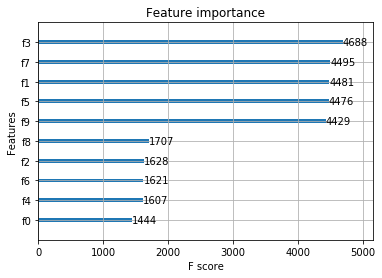

In [274]:
xgb.plot_importance(gbm)

In [287]:
#xgb.to_graphviz(gbm, num_trees=26)

## Encoding features

In [ ]:
def encode_cat_variables(x, help_dict = None):
    uniqs = np.unique(x)
    if help_dict is None: help_dict = {v:k+1 for k, v in enumerate(uniqs)}
    levels = len(help_dict.keys()) + 1
    x_t = np.array([help_dict.get(x_i, 0) for x_i in x])
    return x_t, help_dict, levels

In [246]:
def split_num_cat_columns(X, cutoff=50):
    cat_ind = []
    cont_ind = []
    for i in range(X.shape[1]):
        uniqs_len = len(np.unique(X[:,i]))
        fraction = uniqs_len/X.shape[0]
        if uniqs_len <= 2 or fraction > 0.05 or uniqs_len > cutoff:
            cont_ind.append(i)
        else:
            cat_ind.append(i)
    return cat_ind, cont_ind 

In [258]:
def transform_dataset(train_X, valid_X, test_X, cutoff=50):
    
    cat_ind, cont_ind = split_num_cat_columns(train_X, cutoff)
    
    train_X_cat = train_X[:, cat_ind]
    train_X_cont = train_X[:, cont_ind]
    
    valid_X_cat = valid_X[:, cat_ind]
    valid_X_cont = valid_X[:, cont_ind]
    
    test_X_cat = test_X[:, cat_ind]
    test_X_cont = test_X[:, cont_ind]
    
    if len(cont_ind) > 0:
        scaler = StandardScaler()
        train_X_cont = scaler.fit_transform(train_X_cont)
        valid_X_cont = scaler.transform(valid_X_cont)
        test_X_cont = scaler.transform(test_X_cont)
    
    level_arr = [0]*train_X_cat.shape[1]
    for i in range(train_X_cat.shape[1]):
        x, help_arr, levels = encode_cat_variables(train_X_cat[:,i])
        train_X_cat[:,i] = x
        level_arr[i] = levels
        x, _, _ = encode_cat_variables(valid_X_cat[:,i], help_arr)
        valid_X_cat[:,i] = x
        x, _, _ = encode_cat_variables(test_X_cat[:,i], help_arr)
        test_X_cat[:,i] = x
    return (train_X_cat, train_X_cont, valid_X_cat, valid_X_cont, test_X_cat, test_X_cont), level_arr

## Dataset

In [177]:
class TabularDataSet(Dataset):
    def __init__(self, X_cat, X_cont, Y):
        self.X_cat = X_cat
        self.X_cont = X_cont
        self.Y = Y

    def __getitem__(self, index):
        return self.X_cat[index], self.X_cont[index], self.Y[index]

    def __len__(self):
        return len(self.Y)

## Training functions

In [68]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [69]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations, div_start=5, div_end=5):
    min_start, min_end = max_lr/div_start, max_lr/div_end
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

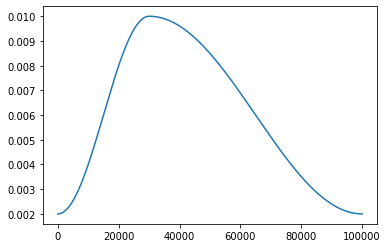

In [70]:
N = 100000
lr = get_cosine_triangular_lr(0.01, N)
plt.plot(list(range(N)), lr)
plt.show()

In [71]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [72]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat = []
    ys = []
    for x1, x2, y in valid_dl:
        batch = y.shape[0]
        y = y.unsqueeze(1).float()
        out = model(x1.long().cuda(), x2.float().cuda())
        loss = F.mse_loss(out, y.cuda())
        sum_loss += batch*(loss.item())
        total += batch
        y_hat.append(out.detach().cpu().numpy())
        ys.append(y)
    
    y_hat = np.vstack(y_hat)
    ys = np.vstack(ys)
    r2 = metrics.r2_score(ys, y_hat)
    return sum_loss/total, r2

In [73]:
def train_model(model, train_dl, valid_dl, optimizer, max_lr=0.05, epochs=100):
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    idx = 0
    best_val_r2 = 0
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    for t in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x1, x2, y in train_dl:
            update_optimizer(optimizer, lrs[idx])
            x1 = x1.cuda().long()
            x2 = x2.cuda().float()
            y = y.unsqueeze(1).cuda().float()
            y_hat = model(x1, x2)
            loss = F.mse_loss(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*y.size(0)
            total += y.size(0)
            idx +=1
            pbar.update()
        val_loss, val_r2 = val_metrics(model, valid_dl)
        print("\tTrain loss: {:.3f} \t Valid loss: {:.3f} \t Valid R2:  {:.3f}".format(
            total_loss/total, val_loss, val_r2))  
        if best_val_r2 < val_r2:
            best_val_r2 = val_r2
            path = "{0}/models/model_{1}_acc_{2:.0f}.pth".format(PATH, dataset, 100*val_r2) 
            save_model(model, path)
            print(path)
            
    print("Best valid r2: {:.3f}".format(best_val_r2))
    return best_val_r2

## Baseline model 

In [153]:
class TabularNet(nn.Module):
    def __init__(self, num_cont, num_cat, level_arr, hidden_dim=500):
        super(TabularNet, self).__init__()
        in_dim = num_cont + 2*num_cat
        in_dim2 = hidden_dim + in_dim
        self.embs = nn.ModuleList([nn.Embedding(level_arr[i], 2) for i in range(len(level_arr))])
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(in_dim2, hidden_dim)
        self.linear3 = nn.Linear(in_dim2, hidden_dim)
        self.linear4 = nn.Linear(in_dim2, hidden_dim)
        self.linear5 = nn.Linear(in_dim2, 1)
        self.dropout = nn.Dropout(0.2)
                                  
    def forward(self, x_cat, x_cont):
        x_cat = [self.embs[i](x_cat[:,i]) for i in range(x_cat.size(1))]
        x_cat = torch.cat(x_cat, dim=1)
        x_cat = self.dropout(x_cat)
        x = torch.cat([x_cont, x_cat], dim=1)
        x1 = self.bn1(F.relu(self.linear1(x)))
        x1 = self.dropout(x1)
        x1 = torch.cat([x, x1], dim=1)
        x1 = self.bn2(F.relu(self.linear2(x1)))
        x1 = self.dropout(x1)
        x1 = torch.cat([x, x1], dim=1)
        x1 = self.bn3(F.relu(self.linear3(x1)))
        x1 = torch.cat([x, x1], dim=1)
        x1 = self.bn4(F.relu(self.linear4(x1)))
        x1 = torch.cat([x, x1], dim=1)
        return self.linear5(x1)

In [283]:
dataset = datasets[6]
print(dataset)
train_X, valid_X, test_X, train_y, valid_y, test_y = split_dataset(dataset)
cat_ind, cont_ind  = split_num_cat_columns(train_X, cutoff=12)
cat_ind, cont_ind 

1595_poker


([0, 2, 4, 6, 8], [1, 3, 5, 7, 9])

In [284]:
(train_X_cat, train_X_cont, valid_X_cat, valid_X_cont, test_X_cat, test_X_cont), \
level_arr = transform_dataset(train_X, valid_X, test_X, cutoff=12)

In [285]:
train_ds = TabularDataSet(train_X_cat, train_X_cont, train_y)
valid_ds = TabularDataSet(valid_X_cat, valid_X_cont, valid_y)
test_ds = TabularDataSet(test_X_cat, test_X_cont, test_y)

In [286]:
level_arr

[5, 5, 5, 5, 5]

In [287]:
batch_size = 100000

num_cont = len(cont_ind)
num_cat = len(cat_ind)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [288]:
model = TabularNet(num_cont, num_cat, level_arr, hidden_dim=200).cuda()

In [289]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=1e-5)
best_r2 = train_model(model, train_dl, valid_dl, optimizer, epochs=100)

	Train loss: 2.656 	 Valid loss: 0.899 	 Valid R2:  -0.525
	Train loss: 0.746 	 Valid loss: 0.655 	 Valid R2:  -0.112
	Train loss: 0.638 	 Valid loss: 0.638 	 Valid R2:  -0.082
	Train loss: 0.601 	 Valid loss: 0.587 	 Valid R2:  0.004
/data2/yinterian/pmlb/models/model_1595_poker_acc_0.pth
	Train loss: 0.583 	 Valid loss: 0.558 	 Valid R2:  0.052
/data2/yinterian/pmlb/models/model_1595_poker_acc_5.pth
	Train loss: 0.573 	 Valid loss: 0.553 	 Valid R2:  0.062
/data2/yinterian/pmlb/models/model_1595_poker_acc_6.pth
	Train loss: 0.569 	 Valid loss: 0.550 	 Valid R2:  0.068
/data2/yinterian/pmlb/models/model_1595_poker_acc_7.pth
	Train loss: 0.565 	 Valid loss: 0.547 	 Valid R2:  0.073
/data2/yinterian/pmlb/models/model_1595_poker_acc_7.pth
	Train loss: 0.563 	 Valid loss: 0.544 	 Valid R2:  0.076
/data2/yinterian/pmlb/models/model_1595_poker_acc_8.pth
	Train loss: 0.560 	 Valid loss: 0.541 	 Valid R2:  0.082
/data2/yinterian/pmlb/models/model_1595_poker_acc_8.pth
	Train loss: 0.557 	 Vali

	Train loss: 0.067 	 Valid loss: 0.053 	 Valid R2:  0.911
	Train loss: 0.066 	 Valid loss: 0.052 	 Valid R2:  0.912
/data2/yinterian/pmlb/models/model_1595_poker_acc_91.pth
	Train loss: 0.066 	 Valid loss: 0.052 	 Valid R2:  0.912
	Train loss: 0.066 	 Valid loss: 0.052 	 Valid R2:  0.911
	Train loss: 0.065 	 Valid loss: 0.053 	 Valid R2:  0.911
	Train loss: 0.065 	 Valid loss: 0.053 	 Valid R2:  0.910
	Train loss: 0.065 	 Valid loss: 0.051 	 Valid R2:  0.913
/data2/yinterian/pmlb/models/model_1595_poker_acc_91.pth
	Train loss: 0.065 	 Valid loss: 0.051 	 Valid R2:  0.913
	Train loss: 0.064 	 Valid loss: 0.052 	 Valid R2:  0.912
	Train loss: 0.064 	 Valid loss: 0.051 	 Valid R2:  0.913
	Train loss: 0.065 	 Valid loss: 0.052 	 Valid R2:  0.912
	Train loss: 0.065 	 Valid loss: 0.051 	 Valid R2:  0.913
/data2/yinterian/pmlb/models/model_1595_poker_acc_91.pth
	Train loss: 0.064 	 Valid loss: 0.052 	 Valid R2:  0.912
	Train loss: 0.064 	 Valid loss: 0.051 	 Valid R2:  0.914
/data2/yinterian/

In [290]:
best_r2

0.9145632767765612

In [267]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=1e-5)
best_r2 = train_model(model, train_dl, valid_dl, optimizer, epochs=100)

	Train loss: 2.302 	 Valid loss: 0.749 	 Valid R2:  -0.271
	Train loss: 0.815 	 Valid loss: 0.639 	 Valid R2:  -0.084
	Train loss: 0.681 	 Valid loss: 0.661 	 Valid R2:  -0.122
	Train loss: 0.624 	 Valid loss: 0.596 	 Valid R2:  -0.012
	Train loss: 0.596 	 Valid loss: 0.567 	 Valid R2:  0.038
/data2/yinterian/pmlb/models/model_1595_poker_acc_4.pth
	Train loss: 0.581 	 Valid loss: 0.562 	 Valid R2:  0.047
/data2/yinterian/pmlb/models/model_1595_poker_acc_5.pth
	Train loss: 0.574 	 Valid loss: 0.553 	 Valid R2:  0.061
/data2/yinterian/pmlb/models/model_1595_poker_acc_6.pth
	Train loss: 0.570 	 Valid loss: 0.552 	 Valid R2:  0.063
/data2/yinterian/pmlb/models/model_1595_poker_acc_6.pth
	Train loss: 0.567 	 Valid loss: 0.549 	 Valid R2:  0.068
/data2/yinterian/pmlb/models/model_1595_poker_acc_7.pth
	Train loss: 0.565 	 Valid loss: 0.547 	 Valid R2:  0.072
/data2/yinterian/pmlb/models/model_1595_poker_acc_7.pth
	Train loss: 0.563 	 Valid loss: 0.546 	 Valid R2:  0.074
/data2/yinterian/pmlb/

	Train loss: 0.062 	 Valid loss: 0.049 	 Valid R2:  0.917
	Train loss: 0.061 	 Valid loss: 0.046 	 Valid R2:  0.922
/data2/yinterian/pmlb/models/model_1595_poker_acc_92.pth
	Train loss: 0.062 	 Valid loss: 0.044 	 Valid R2:  0.926
/data2/yinterian/pmlb/models/model_1595_poker_acc_93.pth
	Train loss: 0.060 	 Valid loss: 0.045 	 Valid R2:  0.923
	Train loss: 0.061 	 Valid loss: 0.046 	 Valid R2:  0.922
	Train loss: 0.060 	 Valid loss: 0.046 	 Valid R2:  0.922
	Train loss: 0.060 	 Valid loss: 0.045 	 Valid R2:  0.923
	Train loss: 0.059 	 Valid loss: 0.044 	 Valid R2:  0.925
	Train loss: 0.058 	 Valid loss: 0.048 	 Valid R2:  0.919
	Train loss: 0.059 	 Valid loss: 0.043 	 Valid R2:  0.927
/data2/yinterian/pmlb/models/model_1595_poker_acc_93.pth
	Train loss: 0.058 	 Valid loss: 0.046 	 Valid R2:  0.921
	Train loss: 0.058 	 Valid loss: 0.046 	 Valid R2:  0.923
	Train loss: 0.059 	 Valid loss: 0.043 	 Valid R2:  0.927
Best valid r2: 0.927


In [268]:
best_r2

0.927311149704626

## Sparse model 

In [215]:
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, mask):
        super(MaskedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.mask = nn.Parameter(mask, requires_grad=False)
        
    def update_mask(self, mask):
        self.mask = nn.Parameter(mask, requires_grad=False)
    
    def forward(self, x):
        self.linear.weight.data *= self.mask # to zero it out
        return self.linear(x)

In [216]:
class TabularNetV2(nn.Module):
    def __init__(self, num_cont, num_cat, level_arr, mask, hidden_dim2=50):
        super(TabularNetV2, self).__init__()
        in_dim = num_cont + 2*num_cat
        hidden_dim = mask.shape[0]
        self.embs = nn.ModuleList([nn.Embedding(level_arr[i], 2) for i in range(len(level_arr))])
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.linear1 = MaskedLinear(in_dim, hidden_dim, mask)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(0.2)
                                  
    def forward(self, x_cat, x_cont):
        x_cat = [self.embs[i](x_cat[:,i]) for i in range(x_cat.size(1))]
        x_cat = torch.cat(x_cat, dim=1)
        x_cat = self.dropout(x_cat)
        x = torch.cat([x_cont, x_cat], dim=1)
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.dropout(x)
        x = self.bn2(F.relu(self.linear2(x)))
        return self.linear3(x)

In [217]:
class TabularNetV2Cont(nn.Module):
    def __init__(self, num_cont, mask, hidden_dim2=1000):
        super(TabularNetV2Cont, self).__init__()
        in_dim = num_cont + 2*num_cat
        hidden_dim = mask.shape[0]
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.linear1 = MaskedLinear(in_dim, hidden_dim, mask)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim2)
        self.linear3 = nn.Linear(hidden_dim2, 1)
        self.dropout = nn.Dropout(0.2)
                                  
    def forward(self, x_cat, x_cont):
        x = self.bn1(F.relu(self.linear1(x_cont)))
        
        x = self.bn2(F.relu(self.linear2(x)))
        return self.linear3(x)

In [218]:
dataset

'215_2dplanes'

In [219]:
num_cont = len(cont_ind)
num_cat = len(cat_ind)
input_dim = num_cont + 2*num_cat
hidden_dim = 1000
w = torch.ones((hidden_dim, input_dim)).float()

In [220]:
num_cont = len(cont_ind)
num_cat = len(cat_ind)

## Training new model

In [221]:
batch_size = 70000

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [222]:
def get_new_w(model, p=0.05):
    ww = model.linear1.linear.weight.clone()
    ww = ww.cpu().detach()
    mask = model.linear1.mask.cpu()
    ww = ww*mask
    q = np.quantile(np.abs(ww.numpy()), p)
    return (torch.abs(ww) > q).float()

In [234]:
w = torch.ones((hidden_dim, input_dim)).float()

In [235]:
model = TabularNetV2(num_cont, num_cat, level_arr, w).cuda()
#model = TabularNetV2Cont(num_cont, w).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=1e-5)
best_r2 = train_model(model, train_dl, valid_dl, optimizer, epochs=100)

	Train loss: 20.359 	 Valid loss: 13.335 	 Valid R2:  0.317
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_32.pth
	Train loss: 9.258 	 Valid loss: 9.746 	 Valid R2:  0.501
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_50.pth
	Train loss: 7.726 	 Valid loss: 8.063 	 Valid R2:  0.587
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_59.pth
	Train loss: 7.124 	 Valid loss: 7.242 	 Valid R2:  0.629
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_63.pth
	Train loss: 6.634 	 Valid loss: 6.751 	 Valid R2:  0.654
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_65.pth
	Train loss: 6.277 	 Valid loss: 6.543 	 Valid R2:  0.665
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_66.pth
	Train loss: 6.019 	 Valid loss: 6.563 	 Valid R2:  0.664
	Train loss: 5.680 	 Valid loss: 6.699 	 Valid R2:  0.657
	Train loss: 5.318 	 Valid loss: 6.705 	 Valid R2:  0.657
	Train loss: 5.081 	 Valid loss: 6.442 	 Valid R2:  0.670
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_67.pth
	Trai

In [236]:
model = TabularNetV2(num_cont, num_cat, level_arr, w).cuda()
#model = TabularNetV2Cont(num_cont, w).cuda()
path = "{0}/models/model_{1}_acc_{2:.0f}.pth".format(PATH, dataset, 100*best_r2) 
load_model(model, path)

In [237]:
w = get_new_w(model, p=0.3)
model.linear1.update_mask(w.cuda())

In [238]:
#model = TabularNetV2(num_cont, num_cat, level_arr, w).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
train_model(model, train_dl, valid_dl, optimizer, epochs=15)

	Train loss: 1.981 	 Valid loss: 1.612 	 Valid R2:  0.917
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_92.pth
	Train loss: 2.333 	 Valid loss: 1.363 	 Valid R2:  0.930
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_93.pth
	Train loss: 2.099 	 Valid loss: 1.973 	 Valid R2:  0.899
	Train loss: 2.532 	 Valid loss: 1.198 	 Valid R2:  0.939
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_94.pth
	Train loss: 1.996 	 Valid loss: 1.369 	 Valid R2:  0.930
	Train loss: 2.270 	 Valid loss: 1.492 	 Valid R2:  0.924
	Train loss: 2.001 	 Valid loss: 2.152 	 Valid R2:  0.890
	Train loss: 1.943 	 Valid loss: 2.279 	 Valid R2:  0.883
	Train loss: 1.932 	 Valid loss: 1.862 	 Valid R2:  0.905
	Train loss: 1.876 	 Valid loss: 1.516 	 Valid R2:  0.922
	Train loss: 1.843 	 Valid loss: 1.376 	 Valid R2:  0.930
	Train loss: 1.813 	 Valid loss: 1.326 	 Valid R2:  0.932
	Train loss: 1.756 	 Valid loss: 1.301 	 Valid R2:  0.933
	Train loss: 1.762 	 Valid loss: 1.274 	 Valid R2:  0.935
	Train loss

0.9386260179674757

In [239]:
model = TabularNetV2(num_cont, num_cat, level_arr, w).cuda()
#model = TabularNetV2Cont(num_cont, w).cuda()
path = "{0}/models/model_{1}_acc_{2:.0f}.pth".format(PATH, dataset, 100*best_r2) 
load_model(model, path)

In [240]:
w = get_new_w(model, p=0.5)
model.linear1.update_mask(w.cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=1e-5)
train_model(model, train_dl, valid_dl, optimizer, epochs=15)

	Train loss: 2.062 	 Valid loss: 1.723 	 Valid R2:  0.912
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_91.pth
	Train loss: 2.180 	 Valid loss: 1.176 	 Valid R2:  0.940
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_94.pth
	Train loss: 1.913 	 Valid loss: 1.779 	 Valid R2:  0.909
	Train loss: 2.428 	 Valid loss: 1.614 	 Valid R2:  0.917
	Train loss: 1.984 	 Valid loss: 2.138 	 Valid R2:  0.890
	Train loss: 2.102 	 Valid loss: 1.368 	 Valid R2:  0.930
	Train loss: 1.850 	 Valid loss: 1.387 	 Valid R2:  0.929
	Train loss: 1.977 	 Valid loss: 1.337 	 Valid R2:  0.932
	Train loss: 1.829 	 Valid loss: 1.485 	 Valid R2:  0.924
	Train loss: 1.759 	 Valid loss: 1.670 	 Valid R2:  0.914
	Train loss: 1.783 	 Valid loss: 1.611 	 Valid R2:  0.917
	Train loss: 1.725 	 Valid loss: 1.458 	 Valid R2:  0.925
	Train loss: 1.713 	 Valid loss: 1.350 	 Valid R2:  0.931
	Train loss: 1.672 	 Valid loss: 1.300 	 Valid R2:  0.933
	Train loss: 1.678 	 Valid loss: 1.286 	 Valid R2:  0.934
Best valid r

0.9397820864297147

In [241]:
w = get_new_w(model, p=0.7)
model.linear1.update_mask(w.cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=1e-5)
train_model(model, train_dl, valid_dl, optimizer, epochs=15)

	Train loss: 1.724 	 Valid loss: 1.409 	 Valid R2:  0.928
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_93.pth
	Train loss: 1.792 	 Valid loss: 2.195 	 Valid R2:  0.888
	Train loss: 1.758 	 Valid loss: 2.178 	 Valid R2:  0.888
	Train loss: 1.826 	 Valid loss: 1.503 	 Valid R2:  0.923
	Train loss: 1.750 	 Valid loss: 1.816 	 Valid R2:  0.907
	Train loss: 1.775 	 Valid loss: 1.426 	 Valid R2:  0.927
	Train loss: 1.680 	 Valid loss: 1.205 	 Valid R2:  0.938
/data2/yinterian/pmlb/models/model_215_2dplanes_acc_94.pth
	Train loss: 1.665 	 Valid loss: 1.344 	 Valid R2:  0.931
	Train loss: 1.667 	 Valid loss: 1.481 	 Valid R2:  0.924
	Train loss: 1.641 	 Valid loss: 1.434 	 Valid R2:  0.927
	Train loss: 1.599 	 Valid loss: 1.317 	 Valid R2:  0.933
	Train loss: 1.560 	 Valid loss: 1.300 	 Valid R2:  0.933
	Train loss: 1.561 	 Valid loss: 1.358 	 Valid R2:  0.930
	Train loss: 1.545 	 Valid loss: 1.439 	 Valid R2:  0.926
	Train loss: 1.573 	 Valid loss: 1.516 	 Valid R2:  0.922
Best valid r

0.9382783273771009

In [174]:
mask = model.linear1.mask.cpu()

In [181]:
rank = mask.sum(0)/mask.sum(0).max()

In [182]:
torch.sort(rank, dim=0, descending=True)

torch.return_types.sort(
values=tensor([1.0000, 0.6661, 0.6608, 0.6396, 0.6219, 0.6042, 0.5389, 0.5247, 0.5088,
        0.4982, 0.4682, 0.4629, 0.4594, 0.4523, 0.4470, 0.4435, 0.4117, 0.3463,
        0.3163]),
indices=tensor([ 0,  4,  2,  9,  7, 17,  1,  5,  8, 10,  6, 12, 14, 16, 18, 11, 13,  3,
        15]))

In [186]:
#model = TabularNetV2Cont(num_cont, mask).cuda()
model = TabularNetV2(num_cont, num_cat, level_arr, w).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=1e-5)
best_r2 = train_model(model, train_dl, valid_dl, optimizer, epochs=100)

	Train loss: 17.008 	 Valid loss: 13.658 	 Valid R2:  0.323
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_32.pth
	Train loss: 10.355 	 Valid loss: 12.687 	 Valid R2:  0.371
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_37.pth
	Train loss: 9.916 	 Valid loss: 12.731 	 Valid R2:  0.369
	Train loss: 9.676 	 Valid loss: 12.923 	 Valid R2:  0.359
	Train loss: 9.514 	 Valid loss: 13.232 	 Valid R2:  0.344
	Train loss: 9.375 	 Valid loss: 13.256 	 Valid R2:  0.343
	Train loss: 9.236 	 Valid loss: 12.770 	 Valid R2:  0.367
	Train loss: 9.041 	 Valid loss: 12.094 	 Valid R2:  0.400
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_40.pth
	Train loss: 8.905 	 Valid loss: 11.609 	 Valid R2:  0.425
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_42.pth
	Train loss: 8.764 	 Valid loss: 11.175 	 Valid R2:  0.446
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_45.pth
	Train loss: 8.691 	 Valid loss: 10.597 	 Valid R2:  0.475
/data2/yinterian/pmlb/models/

## Training baseline model

In [52]:
batch_size = 100000

num_cont = len(cont_ind)
num_cat = len(cat_ind)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [53]:
model = TabularNet(num_cont, num_cat, level_arr).cuda()

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.5, weight_decay=1e-5)
train_model(model, train_dl, valid_dl, optimizer, epochs=100)

	Train loss: 21.470 	 Valid loss: 45.292 	 Valid R2:  -1.245
	Train loss: 66.181 	 Valid loss: 21.515 	 Valid R2:  -0.067
	Train loss: 19.850 	 Valid loss: 58.539 	 Valid R2:  -1.902
	Train loss: 20.108 	 Valid loss: 30.373 	 Valid R2:  -0.506
	Train loss: 12.879 	 Valid loss: 43.650 	 Valid R2:  -1.164
	Train loss: 11.617 	 Valid loss: 48.204 	 Valid R2:  -1.390
	Train loss: 12.677 	 Valid loss: 34.346 	 Valid R2:  -0.703
	Train loss: 11.174 	 Valid loss: 22.603 	 Valid R2:  -0.120
	Train loss: 10.258 	 Valid loss: 16.629 	 Valid R2:  0.176
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_18.pth
	Train loss: 10.683 	 Valid loss: 14.435 	 Valid R2:  0.284
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_28.pth
	Train loss: 10.182 	 Valid loss: 17.145 	 Valid R2:  0.150
	Train loss: 9.726 	 Valid loss: 18.808 	 Valid R2:  0.068
	Train loss: 9.776 	 Valid loss: 13.626 	 Valid R2:  0.325
/data2/yinterian/pmlb/models/model_1203_BNG_pwLinear_acc_32.pth
	Train loss: 9.471 	 V

0.612785346890947